# Using 2657 tournament matches of Hikaru Nakamura to train a chess engine
This notebook trains a deep neural network with 2657 tournament matches of the top player H. Nakamura to play chess.

<img src="Model.svg">

In [1]:
import chess.pgn
import torch
import numpy as np
import os, os.path
import timeit

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from adabelief_pytorch import AdaBelief

from util import *

device = torch.device("cuda")

## Loading the games

In [2]:
# loading the games
DIR = 'data/Raw_game/Raw_game/Nakamura/'
games = []
numberOfGames = 0
start = timeit.default_timer()
for name in os.listdir(DIR):
    numberOfGames += 1
    games.append(chess.pgn.read_game(open(DIR+name)))
stop = timeit.default_timer()
print("Loaded", numberOfGames, "games in", stop - start, "seconds.")

Loaded 2657 games in 7.871836798000004 seconds.


## Datastructure

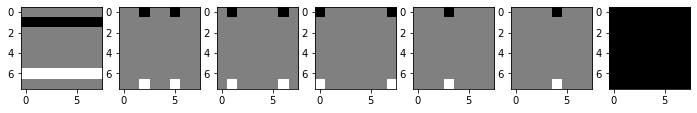

In [3]:
boardMap = boardToTensor(games[0].board(), "b")[0]
fig = plt.figure(figsize=(12,7))
figNo = 1
for i in range(7):
    fig.add_subplot(1,7, figNo)
    plt.imshow(boardMap[i], cmap="gray")
    figNo += 1
plt.show()

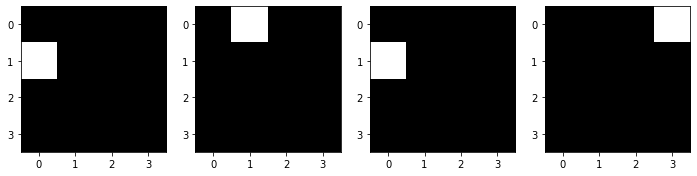

In [4]:
moveMap = moveToTensor("e2e4")
fig = plt.figure(figsize=(12,4))
figNo = 1
for i in range(4):
    fig.add_subplot(1,4, figNo)
    plt.imshow(moveMap[i], cmap="gray")
    figNo += 1
plt.show()

## Preparing the data for training

In [127]:
X, Y = [], []
for i in range(50):
    c = ""
    t = "w"
    board = games[i].board()
    
    # get the color
    if games[i].headers["White"] == "Nakamura, Hi":
        c = "w"
    else:
        c = "b"
    
    for move in games[i].mainline_moves():
        if t == c:
            X.append(boardToTensor(board, c).to(device))
            Y.append(moveToTensor(move).to(device))
            board.push(move)
            t = "a"
        else:
            board.push(move)
            t = c

## Model

In [178]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(7, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = torch.nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = torch.nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = torch.nn.Conv2d(128, 4, kernel_size = 3, stride = 1, padding = 1)
        
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = F.max_pool2d(torch.relu(self.conv2(x)), (2,2))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        return torch.softmax(x.view(4,16),dim=1).view(4,4,4)

In [179]:
model = Net().to(device)
optimizer = AdaBelief(model.parameters(), lr=1e-3, eps=1e-8, betas=(0.9,0.999), weight_decouple = True, rectify = False)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


## Training

In [181]:
for i in range(100):
    j=0
    for x, y in zip(X,Y):
        optimizer.zero_grad()
        #print(x, y)
        y_pred = model(x)
        
        single_loss = loss_function(y_pred, y)
        single_loss.backward()
        optimizer.step()
    print(f"Epoch: {i}. Loss: {single_loss.item()}", end="\r")
    #writer.add_scalar('Loss/train', single_loss.item(), i)

## Evaluation

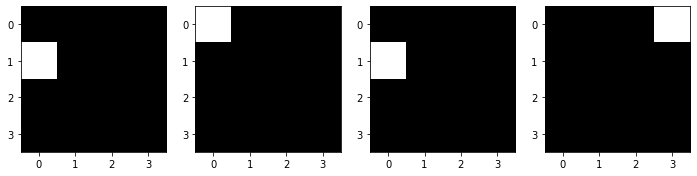

In [201]:
fig = plt.figure(figsize=(12,4))
figNo = 1
for i in range(4):
    fig.add_subplot(1,4, figNo)
    plt.imshow(Y[106][i].cpu(), cmap="gray")
    figNo += 1
plt.show()

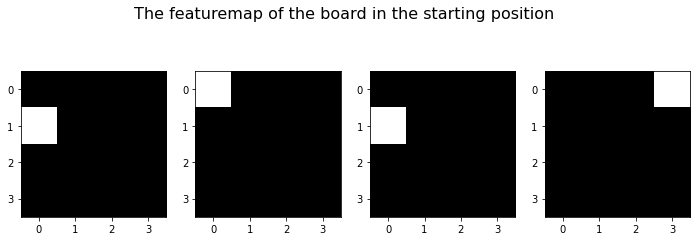

In [190]:
out = model(X[106]).detach().cpu()
fig = plt.figure(figsize=(12,4))
figNo = 1
fig.suptitle("The featuremap of the board in the starting position",fontsize=16)
for i in range(4):
    fig.add_subplot(1,4, figNo)
    plt.imshow(out[i], cmap="gray")
    figNo += 1
plt.show()

In [208]:
torch.save(model.state_dict(), "trained/model100Games.pt") # saving the model